In [538]:
# Install a pip package in the current Jupyter kernel
import sys
import json
from json import JSONEncoder
import numpy as np
import pandas as pd
# !{sys.executable} -m pip install flatten_json
from flatten_json import flatten
# !{sys.executable} -m pip install seaborn
import seaborn as sns
# !{sys.executable} -m pip install MatplotLib
import matplotlib.pyplot as plt



In [539]:
race_id = "PaulRicardS5"
race_type = "sprint"
file_name = 'NewData//201026_213001_R1.json'
save_name = file_name.split('//')[-1]
save_name = save_name.split('.')[0]
save_name = save_name + '_proc.json'

In [540]:
results_file = open(file_name, 'rb')
results_file_stringify = results_file.read()
results_file.close()
results_json = json.loads(results_file_stringify, strict=False)
leader_board_lines = results_json["sessionResult"]["leaderBoardLines"]
laps = results_json["laps"]
if results_json['sessionType'] == 'R2':
    race_id = race_id + 'R2'


In [541]:
df_laps = pd.DataFrame(laps)
filt3 = df_laps['isValidForBest'] == True
df_laps = df_laps.loc[filt3]
filt = (df_laps['laptime'] < 200000)
df_laps = df_laps.loc[filt]
df_laps

,carId,driverIndex,laptime,isValidForBest,splits
0,1011,0,119904,True,"[36210, 32346, 51348]"
2,1021,0,121119,True,"[35838, 32754, 52527]"
31,1011,0,114918,True,"[32052, 32259, 50607]"
32,1024,0,114966,True,"[32001, 32229, 50736]"
33,1021,0,115527,True,"[32229, 32265, 51033]"
...,...,...,...,...,...
434,1029,0,127464,True,"[34590, 35106, 57768]"
435,1017,0,125814,True,"[34611, 35049, 56154]"
436,1013,0,126207,True,"[34884, 34824, 56499]"
437,1003,0,126957,True,"[34881, 35745, 56331]"


In [542]:
# Create the event
event = pd.DataFrame({ 'race_id':[race_id], 'race_type': [race_type], 'sessionType': [results_json['sessionType']], 'track':[results_json['trackName']], 'useRating': [True]})

In [543]:
event

,race_id,race_type,sessionType,track,useRating
0,PaulRicardS5,sprint,R1,paul_ricard_2019,True


In [544]:
lead_flat = [flatten(d) for d in leader_board_lines]


In [545]:
df_leader = pd.json_normalize(lead_flat)
# list(df_leader.columns)
df_leader = df_leader[['car_carId', 'car_drivers_0_firstName','car_drivers_0_lastName','car_drivers_0_playerId','car_carModel']]
df_leader = df_leader.rename(columns={"car_carId": "carId", "car_drivers_0_firstName": "firstName", "car_drivers_0_lastName": "lastName", "car_drivers_0_playerId" : "steamId"})
df_leader['GT3'] = df_leader['car_carModel'].apply(lambda x: 'GT4' if (x >49 and x < 62) else 'GT3')

In [546]:
lap_data = pd.merge(df_laps, df_leader)
lap_data['Name'] = lap_data['firstName'] + " " + lap_data['lastName']


In [547]:
lap_data['laptime'] = lap_data['laptime'] / 1000
lap_data2 = lap_data.sort_values(by=['laptime'])
lap_data3 = lap_data2.groupby('Name').head(10).reset_index(drop=True)
lap_data3
#list(lap_data2.columns)

,carId,driverIndex,laptime,isValidForBest,splits,firstName,lastName,steamId,car_carModel,GT3,Name
0,1021,0,114.612,True,"[31704, 32220, 50688]",Jonathan,Lee,S76561198170444915,23,GT3,Jonathan Lee
1,1011,0,114.618,True,"[31584, 32382, 50652]",Hamza,Gulzar,S76561198046750315,8,GT3,Hamza Gulzar
2,1011,0,114.660,True,"[31674, 32376, 50610]",Hamza,Gulzar,S76561198046750315,8,GT3,Hamza Gulzar
3,1024,0,114.801,True,"[31839, 32289, 50673]",Branden,Ouellet,S76561198854369294,16,GT3,Branden Ouellet
4,1011,0,114.822,True,"[31542, 32460, 50820]",Hamza,Gulzar,S76561198046750315,8,GT3,Hamza Gulzar
...,...,...,...,...,...,...,...,...,...,...,...
288,1009,0,129.075,True,"[35298, 36279, 57498]",Mark,Barton,S76561198240717452,61,GT4,Mark Barton
289,1022,0,129.129,True,"[36351, 35679, 57099]",Tadas,Liutkus,S76561198059161254,53,GT4,Tadas Liutkus
290,1009,0,130.119,True,"[35112, 35517, 59490]",Mark,Barton,S76561198240717452,61,GT4,Mark Barton
291,1022,0,130.566,True,"[35493, 38031, 57042]",Tadas,Liutkus,S76561198059161254,53,GT4,Tadas Liutkus


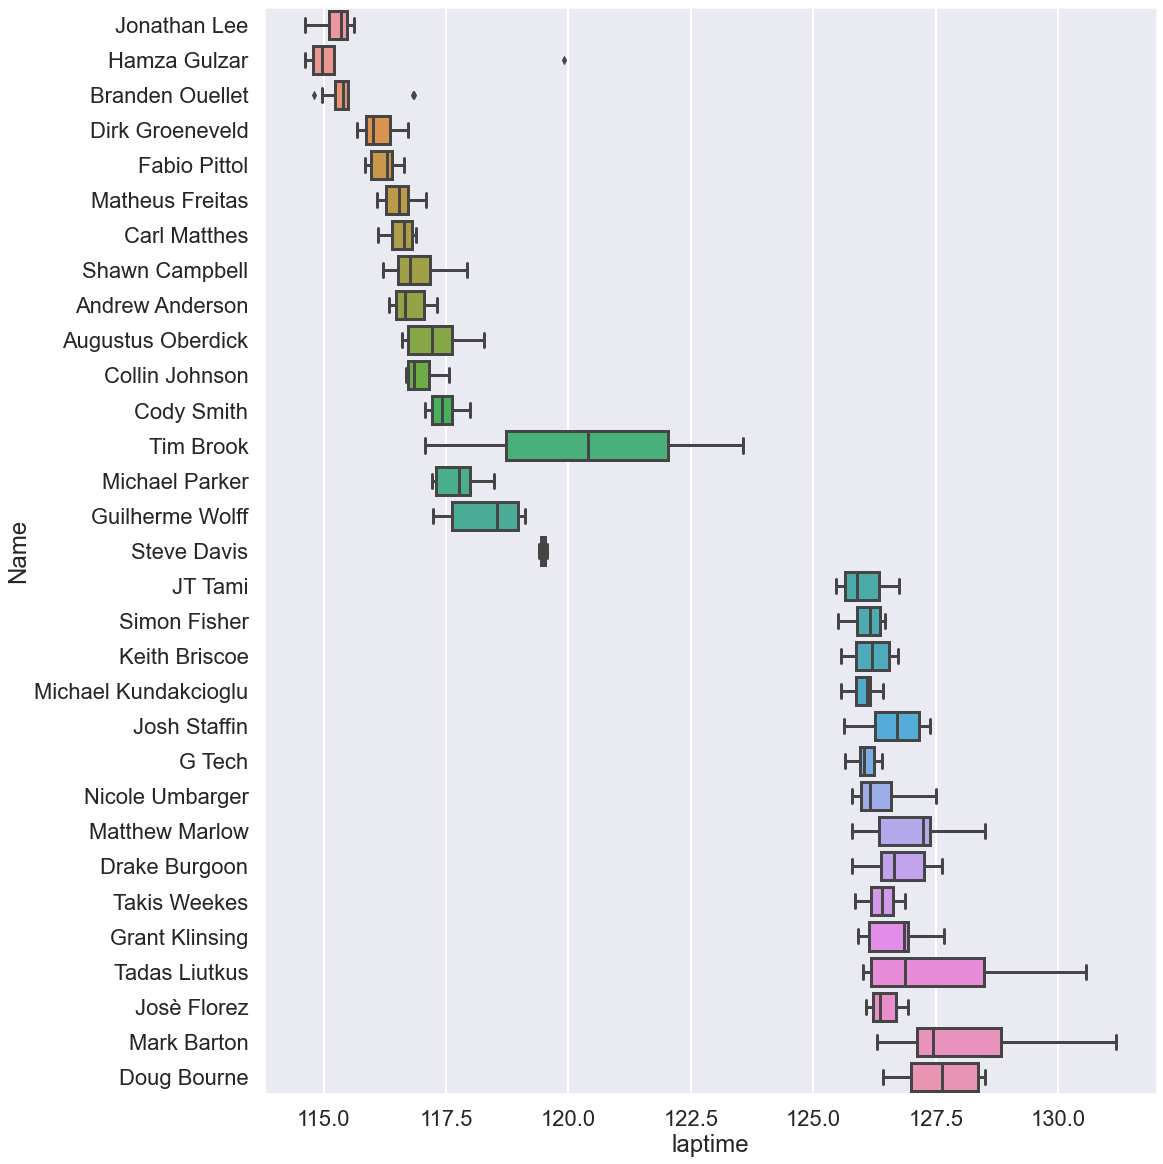

In [548]:
sns.set_context('poster')
sns.set_style("darkgrid")
plt.figure(figsize=(16,20))

sns.boxplot(y='Name', x = 'laptime', data = lap_data3)


In [549]:
def filter_func(x):
    return x['isValidForBest'].count() > 9

In [550]:
lp = lap_data3.groupby(['steamId']).filter(filter_func)

# lp2 = lp.groupby(['carId', 'driverIndex', 'isValidForBest','GT3','steamId' ,'Name']).mean()
lp2 = lp.groupby(['steamId' ]).mean()
lp2.insert(0, 'race_id', event['race_id'][0])

final_data = pd.merge(lp2, df_leader)
final_data = pd.merge(final_data, event)
final_data.to_json(save_name, orient='records')
